# 0. CARREGANDO AS BIBLIOTECAS

In [172]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import SARIMAX

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
from pmdarima.metrics import smape

import warnings
warnings.filterwarnings('ignore')

# 1. CARREGANDO AS BASES DE DADOS

In [75]:
df_item_categories = pd.read_csv("data/item_categories.csv")
df_items = pd.read_csv("data/items.csv")
df_shops = pd.read_csv("data/shops.csv")
df_sales_train = pd.read_csv("data/sales_train.csv")

In [76]:
print(df_item_categories.head())
print(df_items.head())
print(df_shops.head())

        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"  

In [77]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00000000,1.00000000
1,03.01.2013,0,25,2552,899.00000000,1.00000000
2,05.01.2013,0,25,2552,899.00000000,-1.00000000
3,06.01.2013,0,25,2554,1709.05000000,1.00000000
4,15.01.2013,0,25,2555,1099.00000000,1.00000000


# 2. ANÁLISE DESCRITIVA DOS DADOS

In [78]:
print('='*30, 'Descrição das variaveis', '='*30)
print()
print(f'Quantidade de variaveis: {df_sales_train.shape[1]}')
print(f'Quantidade de entrada: {df_sales_train.shape[0]}')

print()
print('identificando os tipos de variaveis')
print()
df_sales_train.info()

============================== Descrição das variaveis ==============================

Quantidade de variaveis: 6
Quantidade de entrada: 2935849

identificando os tipos de variaveis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [79]:
def nulos_e_duplicados (dataframe) :
    print(f'Nulos : {dataframe.isna().sum().sum()}')
    print(f'Duplicados : {dataframe.duplicated().sum()}')

In [80]:
nulos_e_duplicados(df_sales_train)

Nulos : 0
Duplicados : 6


In [81]:
df_sales_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.00000000,14.56991146,9.42298771,0.00000000,7.00000000,14.00000000,23.00000000,33.00000000
shop_id,2935849.00000000,33.00172829,16.22697305,0.00000000,22.00000000,31.00000000,47.00000000,59.00000000
item_id,2935849.00000000,10197.22705698,6324.29735389,0.00000000,4476.00000000,9343.00000000,15684.00000000,22169.00000000
item_price,2935849.00000000,890.85323270,1729.79963071,-1.00000000,249.00000000,399.00000000,999.00000000,307980.00000000
item_cnt_day,2935849.00000000,1.24264089,2.61883443,-22.00000000,1.00000000,1.00000000,1.00000000,2169.00000000


In [82]:
# transformando a variavel date em datetime

df_sales_train['date'] = df_sales_train['date'].astype('datetime64[ns]')

Como o base de dados apresenta só 6 dados dulicados, vamos dropa-lo do datset para uma melhor análise.

In [83]:
#Removendo os dados dulpicados do dataset
df_sales_train.drop_duplicates(inplace=True)
nulos_e_duplicados(df_sales_train)


Nulos : 0
Duplicados : 0


In [84]:
# Ordenando a variavel date de forma crescente para um melhor entedimento gráfico dos dados
df_sales_train  = df_sales_train.sort_values(by= 'date', axis=0, ascending=True).reset_index(drop=True)

In [85]:
df_sales_train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,0,18,16071,249.00000000,1.00000000


# 3. Visualização dos Dados

Vamos, fazer uma visualização de toda a base de dados para um melhor um entedimento mais amplo da base estudada.

In [86]:
# Definindo algumas funções de visualização dos dados

def plot_line(df,x,y, title):
  fig = px.line(df,x=x,y=y, template= 'simple_white', markers= False )
  fig.update_layout(title={'text': title, 'y': 0.98, 'x': 0.5})
  fig.update_xaxes(zeroline = True, zerolinewidth =2, title = '')
  fig.update_yaxes(showticklabels = False, title= '' , showline = False, showticksuffix= 'none', ticks = '')
  fig.show()

In [87]:
#Seperando as variaveis numéricas para plotar nos gráficos
lista = list(df_sales_train.select_dtypes(include='number').columns)

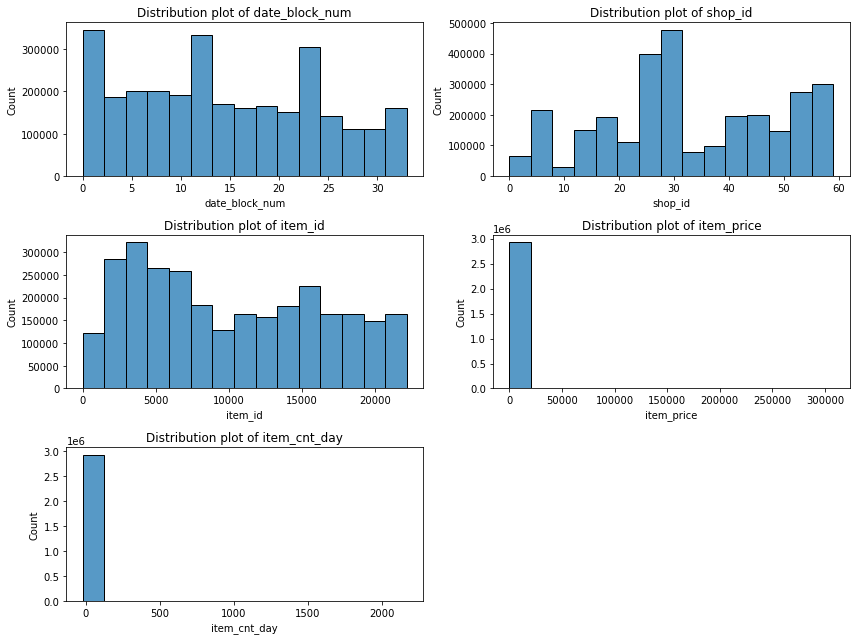

In [88]:
#plotando o histograma das variaveis numéricas
plt.figure(figsize=(12,9))
for i in range(len(lista)):
  plt.subplot(3,2,i+1)
  sns.histplot(x=lista[i], bins=15,data=df_sales_train)
  plt.title('Distribution plot of {}'.format(lista[i]))
  plt.tight_layout()

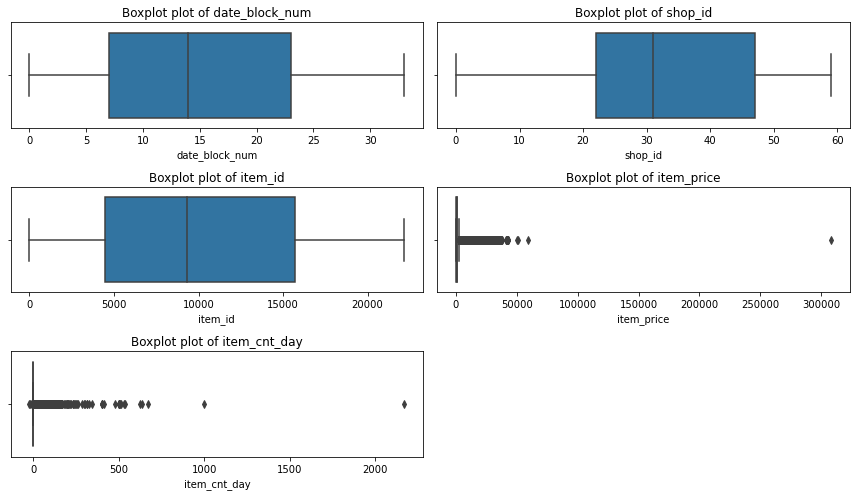

In [89]:
# Plotando o box plot dos dados numéricos
plt.figure(figsize=(12,7))
for i in range(len(lista)):
  plt.subplot(3,2,i+1)
  sns.boxplot(df_sales_train[lista[i]])
  plt.title('Boxplot plot of {}'.format(lista[i]))
  plt.tight_layout()

Os dados do histograma acima mostram a distribuição dos dados. Os pontos importantes, é que a variavel shop_id correspondentes as lojas, mostrou que temos mais frequencia da loja 31. Já as variaveis Item_price e item_cnt_day indicaram pontos de outliers, como mostra os box-plot abaixo. Não, vamos fazer o tratamento de outliers ainda , por que esse ainda não é o dataset final que irá ser trabalhado para o modelo.

In [90]:
figura = pd.DataFrame(df_sales_train.groupby('date')['item_cnt_day'].sum()).reset_index()
plot_line(figura,'date','item_cnt_day', 'Quantidade de vendas dos Produtos por dia')

O gráfico nos mostra uma leve tendencia de queda com o passar do tempo, principalmente a partir de 2015.

## 3.1 Visualizando os dados por Produto

In [91]:
#Filtrando o produto por quantindade de vendas para melhor visualização
item_top10 = pd.DataFrame(df_sales_train.groupby('item_id')['item_cnt_day'].sum()\
                        .rename({'item_cnt_day': 'quantidade'}, axis='columns'))\
                        .sort_values(by = ['item_cnt_day'], ascending = False )\
                            .reset_index().head(10)

In [92]:
#para uma melhor visulização grafica
item_top10['item_id'] = item_top10['item_id'].astype(str)

In [143]:
fig = px.bar(item_top10, x='item_id', y='item_cnt_day', template= 'simple_white',
 text = 'item_cnt_day', color_discrete_sequence=px.colors.qualitative.T10 )
fig.update_xaxes(zeroline = True, zerolinewidth =2)
fig.update_traces(textposition="outside", texttemplate='%{text:.3s}')
fig.update_xaxes(zeroline = True, zerolinewidth =2, title = 'Item_id' )
fig.update_yaxes(showticklabels = False, title= '' , showline = False, ticks = '')
fig.update_layout(title={'text': 'Os produtos mais vendidos', 'y': 0.98, 'x': 0.5})
fig.show()

No gráfico acima mostra o top 10 de produtos por quantidade de vendas. Por isso, o produto escolhido para análise vai ser o 20949 que apresenta uma saida de produtos perto dos 188k.

A partir disso, vamos filtrar no nossa base o produto escolhido e continuar a análise dos dados.

In [94]:
#Filtrando o produto 20949 na base de dados

Item_20949 = df_sales_train[df_sales_train['item_id'] == 20949].reset_index(drop= True)

In [95]:
Item_20949.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-05,4,53,20949,5.00000000,8.00000000


Com isso, vamos fazer a visualização dos dados do produto escolhido.

In [96]:
figura = pd.DataFrame(Item_20949.groupby('date_block_num')['item_cnt_day'].sum()).reset_index()
plot_line(figura,'date_block_num','item_cnt_day', 'Quantidade de vendas do Produto 20949 por mês')

In [97]:
figura = pd.DataFrame(Item_20949.groupby('date')['item_cnt_day'].sum()).reset_index()
plot_line(figura,'date','item_cnt_day', 'Quantidade de vendas do Produto 20949 por dia')

Os dos gráfico acima, mostram picos de vendas em janeiro de 2014 e 2015 e uma leve tendencia de queda na quantidade de vendas a partir de 2015.

## 3.2 Visualizando os dados por loja

Agora, vamos escolher a loja que vai ser utilizada para análise de forecasting

In [98]:
loja_top10 = pd.DataFrame(Item_20949.groupby('shop_id')['item_cnt_day'].sum()\
    .rename({'item_cnt_day': 'quantidade'}, axis='columns'))\
    .sort_values(by='item_cnt_day', ascending=False)\
    .reset_index().head(10)
loja_top10

,shop_id,item_cnt_day
0,31,19934.00000000
1,25,14343.00000000
2,28,13458.00000000
3,54,12323.00000000
4,42,10514.00000000
5,27,8265.00000000
6,57,6116.00000000
7,47,4530.00000000
8,22,4382.00000000
9,21,4335.00000000


In [99]:
#para uma melhor visulização grafica
loja_top10['shop_id'] = loja_top10['shop_id'].astype(str)

In [100]:
fig = px.bar(loja_top10, x='shop_id', y='item_cnt_day', template= 'simple_white',
 text = 'item_cnt_day', color_discrete_sequence=px.colors.qualitative.T10 )
fig.update_xaxes(zeroline = True, zerolinewidth =2)
fig.update_traces(textposition="outside", texttemplate='%{text:.3s}')
fig.update_xaxes(zeroline = True, zerolinewidth =2, title = 'Item_shop' )
fig.update_yaxes(showticklabels = False, title= '' , showline = False, ticks = '')
fig.update_layout(title={'text': 'As lojas que mais vendem o Produto 20949', 'y': 0.98, 'x': 0.5})
fig.show()

A Loja 31 é que apresenta a maior quantidade desse produto em vendas. Então, é por esse motivo que vai ser a loja escolhida para a nossa análise.

## 3.2 Visualização da loja 31 pelo produto 20949

Agora já escolhemos qual o produto e loja que vamos utilizar para análise. Com isso, vamos fazer mais algumas visualização dos dados, para um melhor entedimento da base final.

In [101]:
# Filtrando a loja da 31 no dataset
df_shop31_Item_20949= Item_20949[Item_20949['shop_id'] == 31].reset_index(drop = True)

In [102]:
df_shop31_Item_20949.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-05,4,31,20949,5.00000000,1.00000000
1,2013-01-06,5,31,20949,5.00000000,29.00000000
2,2013-01-07,6,31,20949,5.00000000,29.00000000
3,2013-01-08,7,31,20949,5.00000000,22.00000000
4,2013-01-09,8,31,20949,5.00000000,41.00000000


### 3.2.1 Análise Descriiva dos Dados

A variavel alvo a ser estudada aqui na análise é <item_cnt_day>, na nos mostra a quantidade de vendas dos produtos, por isso vamos plotaros gráficos agora em função dela.

In [103]:
fig = px.histogram(df_shop31_Item_20949, x='item_cnt_day', template= 'simple_white')
fig.update_layout(title={'text': 'Distribuição da variavel "item_cnt_day"', 'y': 0.98, 'x': 0.5})
fig.update_xaxes(title = 'Quantidade_produto')
fig.update_yaxes(title= 'Frequência')
fig.show()

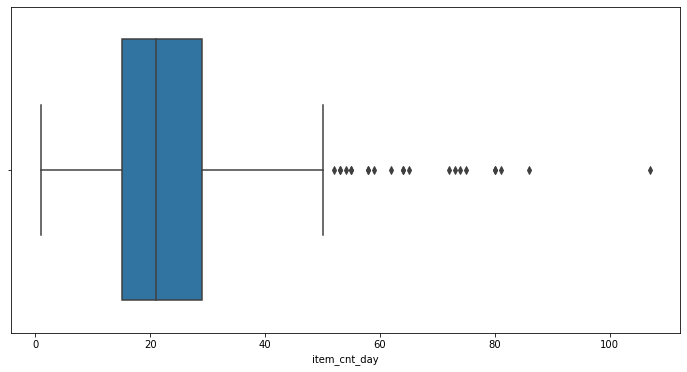

In [104]:
plt.figure(figsize=(12,6))
sns.boxplot(df_shop31_Item_20949['item_cnt_day'])

Como podemos observar no histograma que apreesenta um distribuição assimétrica a direita, com alguns outliers de qunatidades de vendas a partir de 60 em concordância com o gráfico de box-plot abaixo que nos mostra que 50% da qunatidade dos produtos está um pouco acima de 20.

In [105]:
plot_line(df_shop31_Item_20949,'date','item_cnt_day', 'Quantidade de vendas do Produto 20949 por dia')

In [106]:
df_mensal = df_shop31_Item_20949.copy() #fazendo uma cópia do dataset
df_mensal.set_index('date', inplace = True) #transformando a coluna data em index
df_mensal = df_mensal.resample(rule = 'M').last() #reordenando o dataset por mês

In [107]:
plot_line(df_mensal,df_mensal.index,'item_cnt_day', 'Quantidade de vendas do Produto 20949 por mês')

Como podemos observar o produto estudado aqui, tem um saida maior no começo dos anos. Apresenta picos em janeiro de 2014 e em janeiro de 2015.

In [108]:
df_mensal['sales_month'] = df_mensal['item_price'] * df_mensal['item_cnt_day']
plot_line(df_mensal,df_mensal.index,'sales_month', ' Vendas do Produto 20949 por mês')

### 3.2.1 Análise de Correlação

Vamos fazer uma análise de correlação da variavel target em função do tempo para analisar o comportamento.

Text(0.5, 1.0, 'Correlação da quantidade do produto pelo tempo ')

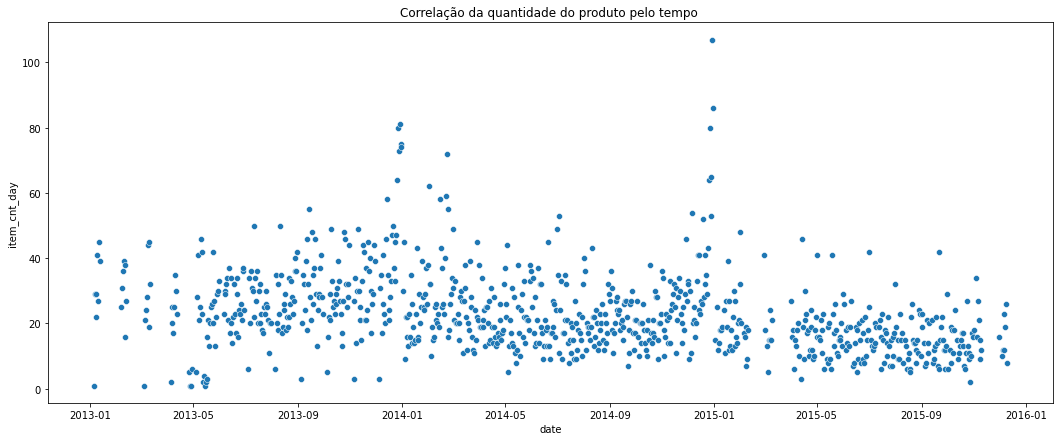

In [109]:
plt.figure(figsize=(18,7))

sns.scatterplot(x='date',y='item_cnt_day',data=df_shop31_Item_20949)
plt.title('Correlação da quantidade do produto pelo tempo ')

A série não apresenta uma correlação alta com o tempo.

# 4. Análise Da Série Temporal 'item_cnt_day'

A partir daqui vamos analisar o comportamento da nossa variavel target, mediante conceitos de séries temporais.

## 4.1 Decomposição dos dados

Vamos decompor os dados em tendencia, sazonalidade e residuos, porque toda série temporal pode ser decomposta nessas trÊs partes.

In [110]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

In [111]:
df_shop31_Item_20949.set_index('date', inplace = True) #transformando a coluna data em index

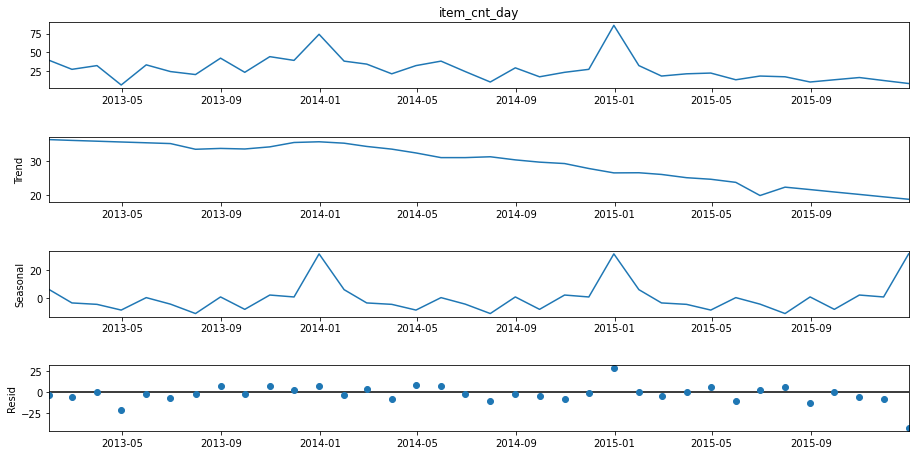

In [112]:
seasonal_decompose (df_mensal['item_cnt_day'])

Claramente a série apresenta uma tendência de baixa a partir de maio de 2014. Apresentando também picos no começo de cada ano, indicando alguma sazonalidade.

## 4.2 Autocorrelação e Autocorrelação Parcial

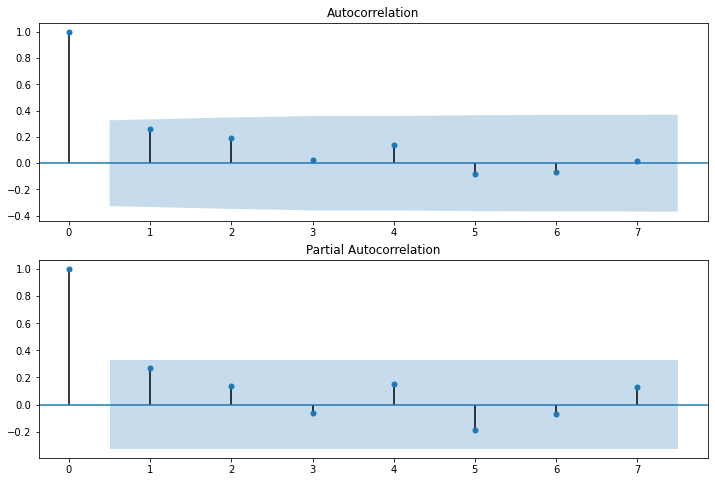

In [145]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_mensal['item_cnt_day'].values.squeeze(), lags=7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_mensal['item_cnt_day'], lags=7, ax=ax2)

Aqui estamos analisando se a série possue alguma correlação com ela mesmo, mas quase nenhum lag tem efeito sobre o periodo atual.Então, vamos seguir:

## 4.3 Estacionariedade da Série

Aqui vamos checar a estacionariedade da série, verificando o comportamento da média ao longo do tempo.

In [114]:
# Definido algumas funções para o teste de estacionariedade
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=3).mean() 
    rolstd = pd.Series(timeseries).rolling(window=3).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

# Teste de Dick fuller
def ADF_test(timeseries, dataDesc):
    print(f' > A série {dataDesc} é estacionária ?')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'Test statistic = {dftest[0]:.3f}')
    print(f'P-value = {dftest[1]:.3f}')
    print('Critical values :')
    for k, v in dftest[4].items():
        print(f'\t{k}: {v} - A base é {"não" if v < dftest[0] else ""} estacionária com {100-int(k[:-1])}% confiança')

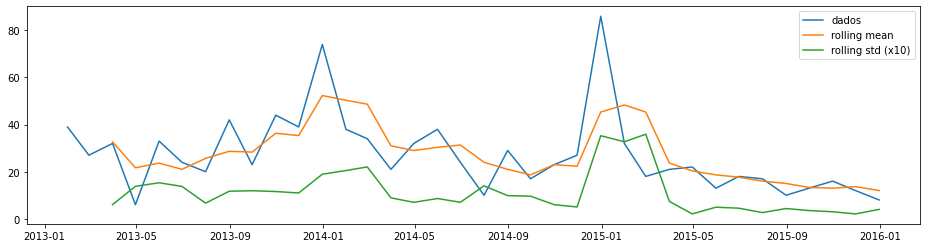

In [115]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(df_mensal['item_cnt_day'], 'dados')

Como podemos verificar a média apresenta dois picos ali, como já comentados em outras análises.

In [118]:
# Aplicando o teste de Dick fuller na série temporal
ADF_test(df_shop31_Item_20949['item_cnt_day'],'attrition')

 > A série attrition é estacionária ?
Test statistic = -4.708
P-value = 0.000
Critical values :
	1%: -3.438066656679015 - A base é  estacionária com 99% confiança
	5%: -2.8649462783472424 - A base é  estacionária com 95% confiança
	10%: -2.5685837702422147 - A base é  estacionária com 90% confiança


O teste de dick fuller, nos mostrou que a série é estacionária com uma confiança de 90%,95% e 99%, mesmo mostrando aqueles picos vistos na sazonalidade e aquela pequena tendencia de queda.

Como a nossa série é estacionária, vamos seguir para a modelagem da mesma.

# 5. Separação da Base de Treino e Teste

In [131]:
x=df_shop31_Item_20949.drop(columns ='item_cnt_day')
y=df_shop31_Item_20949.item_cnt_day

In [120]:
## Função para a separação da base de teste e treino do modelo
def train_test_split(x,y,date_train_star,date_train_end,date_test_star):
  y_train=y.loc[date_train_star:date_train_end]
  x_train =x.loc[date_train_star:date_train_end]
  y_test=y.loc[date_test_star:]
  x_test=x.loc[date_test_star:]
  return x_train, x_test, y_train, y_test

A base de teste do meu dataset vai ser os últimos 31 dias dos dados e bas de treino será o restante.

In [165]:
x_train, x_test, y_train, y_test = train_test_split(x,y, '2013-01-05','2015-10-16', '2015-10-17')

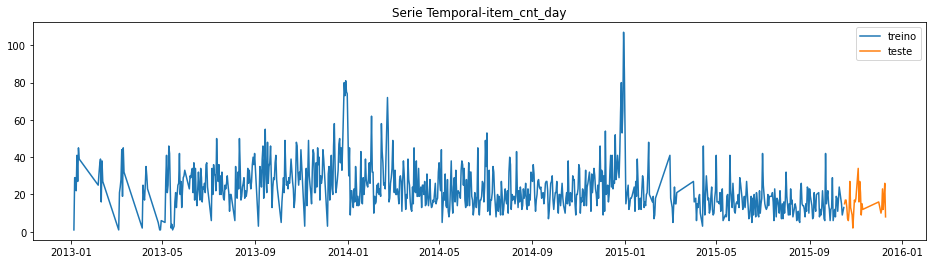

In [166]:
##Visualização da separação da base de treino e teste
plt.figure(figsize=(16,4))
plt.plot(y_train, label= 'treino')
plt.plot(y_test, label= 'teste')
plt.title('Serie Temporal-item_cnt_day')
plt.legend(loc = 'Left corner')
plt.show()

# 6. Modelando a Série Temporal

Para a modelagem da série temporal, foi escohido dois tipos de modelos o ARIMA e a sua derivação o SARIMAX. São modelos estatísticos muito autlizados para esse tipo de abordagem.

## 6.1 Modelando com o Auto-arima

O auto arima irá ser utlizado para encontrar a melhor configuração do seus parametros para essa base de dados.

In [167]:
stepwise =  auto_arima(y,
                    start_p=0,
                    start_q=0,
                    max_order=4,
                    m = 12,
                    seasonal=True,
                    trace=True,
                    test= 'adf',
                    error_action='warn',
                    suppress_warnings=True,
                    stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=7.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6800.411, Time=0.23 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6555.918, Time=5.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6610.671, Time=3.52 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8089.268, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6555.197, Time=1.78 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=6556.062, Time=4.87 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6544.359, Time=14.18 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=6543.762, Time=36.59 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6554.473, Time=14.81 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=35.90 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=6543.593, Time=40.89 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=6555.345, Time=14.81 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=6741.111, Time=33.04 sec
 ARIMA(2,0,0)(1,0,2)[1

In [169]:
  ##Treinamento do modelo com os melhores valores de AIC e BIC
stepwise.fit(y_train)
previsao = stepwise.predict(n_periods=31)
print(stepwise.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  832
Model:             SARIMAX(3, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -3145.334
Date:                                 Tue, 30 Aug 2022   AIC                           6306.668
Time:                                         22:39:19   BIC                           6344.459
Sample:                                              0   HQIC                          6321.159
                                                 - 832                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9421      1.365      1.423      0.155      -0.734       4

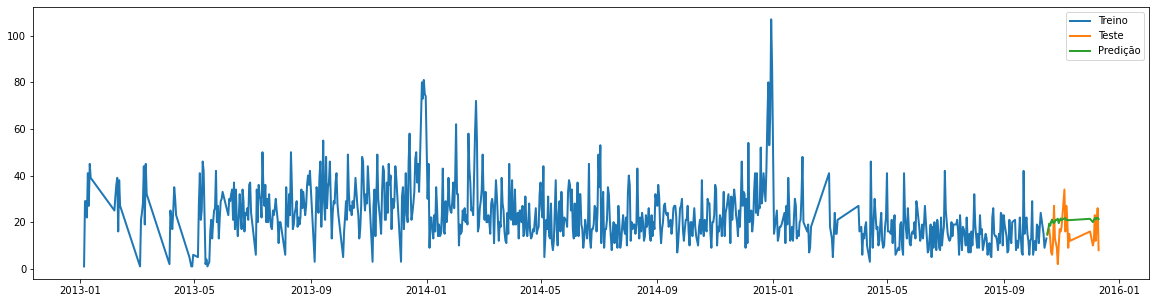

In [170]:
  ##Previsão de 6 meses do modelo arima, com os melhores coeficientes dados no auto-arima
  previsao = pd.DataFrame(previsao,index=y_test.index, columns=['previsão modelo 1'])
  plt.figure(figsize=(20,5))
  plt.plot(y_train, label = 'Treino', linewidth=2)
  plt.plot(y_test, label = 'Teste', linewidth=2)
  plt.plot(previsao, label = 'Predição', linewidth=2)
  plt.legend(loc = 'Left corner')
  plt.show()

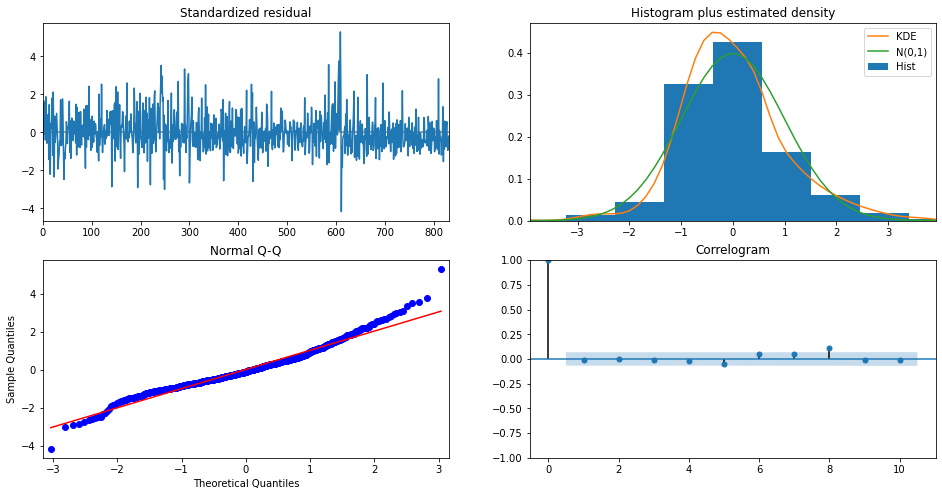

In [171]:
  ##Plot do gráfico de diagnóstico do modelo
  stepwise.plot_diagnostics(figsize=(16, 8))
  plt.show()

In [188]:
d = {'metricas': ['RMSE', 'MAPE', 'MAE', 'RMSLE', 'SMAPE'], 
       'base_teste': [mean_squared_error(y_test, previsao, squared= False),
                       mean_absolute_percentage_error(y_test, previsao),
                      mean_absolute_error(y_test, previsao),
                      mean_squared_log_error(y_test,previsao),
                      smape(y_test,previsao)
                      ] }
tabel_metrics = pd.DataFrame(data = d)
print('='*10,'TABELA DE MÉTRICAS','='*10)
print(tabel_metrics)

========== TABELA DE MÉTRICAS ==========
  metricas  base_teste
0     RMSE  8.72857693
1     MAPE  0.92084962
2      MAE  7.38631562
3    RMSLE  0.37974547
4    SMAPE 46.05545862


## 6.2 Modelando com o Sarimax

                                        SARIMAX Results                                        
Dep. Variable:                            item_cnt_day   No. Observations:                  832
Model:             SARIMAX(3, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -3166.805
Date:                                 Tue, 30 Aug 2022   AIC                           6347.610
Time:                                         22:44:51   BIC                           6380.677
Sample:                                              0   HQIC                          6360.290
                                                 - 832                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4283      0.030     14.224      0.000       0.369       0

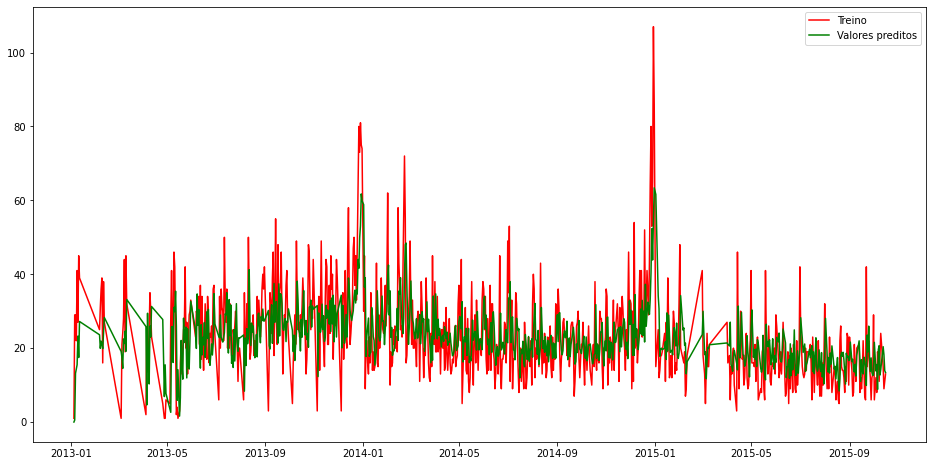

In [173]:
  mod = SARIMAX(y_train, order=(3,0,0), seasonal_order=(1, 0, [1, 2], 12))
  fit_res = mod.fit(disp=False, maxiter=250)
  print(fit_res.summary())

  predito = fit_res.predict(typ='levels')

  ## Plot da previsão da base de treino
  plt.figure(figsize=(16,8))
  plt.plot(y_train, color='red')
  plt.plot(predito,color='green')
  plt.legend(['Treino','Valores preditos'])
  plt.show()

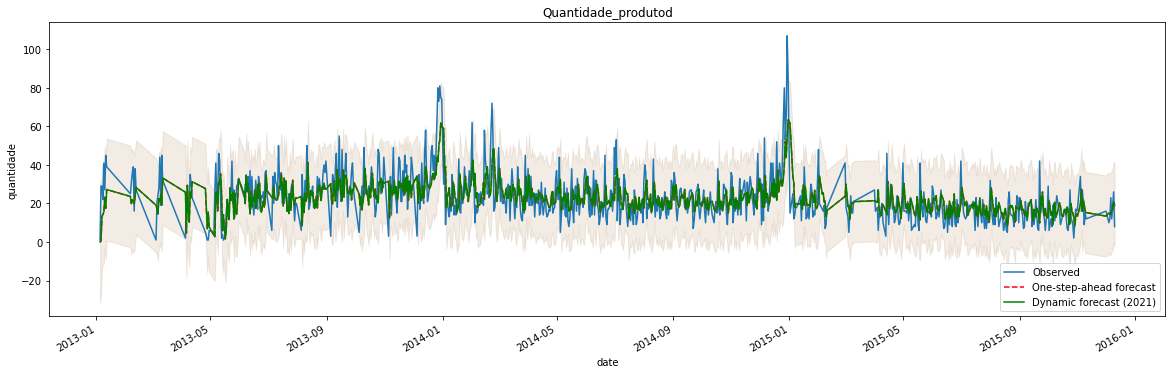

In [182]:
  ## Treinando o modelo com todos os dados para a previsão
  mod = sm.tsa.statespace.SARIMAX(y, order=(3,0,0), seasonal_order=(1, 0, [1, 2], 12))
  res = mod.filter(fit_res.params)

  predict = res.get_prediction()
  predict_ci = predict.conf_int()

  # Predições dinâmicas
  predict_dy = res.get_prediction(dynamic = 2015-10-17)
  predict_dy_ci = predict_dy.conf_int()

  # Gráficos
  fig, ax = plt.subplots(figsize=(20,6))
  npre = 4
  ax.set(title='Quantidade_produtod', xlabel='Date', ylabel='quantidade')

  # Plot da variavel target
  y.plot(ax=ax, style='-', label='Observed')

  # Plot das predições
  predict.predicted_mean.plot(ax=ax, style='r--', label='One-step-ahead forecast')
  ci = predict_ci
  ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.05)
  predict_dy.predicted_mean.plot(ax=ax, style='g', label='Dynamic forecast (2021)')
  ci = predict_dy_ci
  ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.05)

  legend = ax.legend(loc='lower right')
  plt.show()

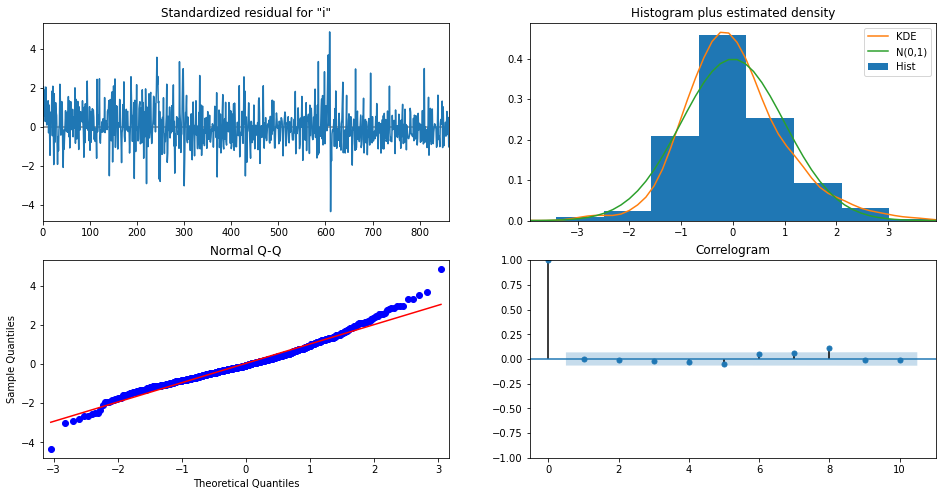

In [180]:
  ##Plot do disgnóstico dos residuos
  res.plot_diagnostics(figsize=(16, 8))
  plt.show()

In [187]:
  d = {'metricas': ['RMSE','MAPE', 'MAE', 'SMAPE'], 
       'base_treino': [mean_squared_error(y_train, predito, squared= False), 
                       mean_absolute_percentage_error(y_train, predito),
                       mean_absolute_error(y_train, predito),
                       smape(y_train, predito)],
       'base_teste': [mean_squared_error(y_test, predict_dy.predicted_mean.loc['2015-10-17':], squared= False), 
                       mean_absolute_percentage_error(y_test, predict_dy.predicted_mean.loc['2015-10-17':]),
                      mean_absolute_error(y_test, predict_dy.predicted_mean.loc['2015-10-17':]),
                      smape(y_test, predict_dy.predicted_mean.loc['2015-10-17':])] }
  tabel_metrics = pd.DataFrame(data = d)
  print('='*10,'TABELA DE MÉTRICAS','='*10)
  print(tabel_metrics)

========== TABELA DE MÉTRICAS ==========
  metricas  base_treino  base_teste
0     RMSE  10.92932122  7.33158057
1     MAPE   0.55209612  0.59967619
2      MAE   8.19081111  5.75344977
3    SMAPE  37.04031453 39.11081101
